# **PREPARE PROCESSING - CLEANING - SPLITTING**

## ***NHẬN KÝ***
+ Ngày 28/10: Sửa lại mục của ngày 26/10.
+ Ngày 30/10: Cập nhật chức năng tái sử dụng data_cleaned

In [77]:
# Load libraries
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
from io import StringIO

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


import warnings

%matplotlib inline
# plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100

warnings.filterwarnings("ignore")

In [78]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

### **Chuẩn bị dữ liệu + xử lý đặc trưng**

#### **Làm sạch dữ liệu (Data Cleaning)**

In [79]:
# Tạo bảng dữ liệu làm sạch
Train_clean = train_data.copy()
Test_clean = test_data.copy()

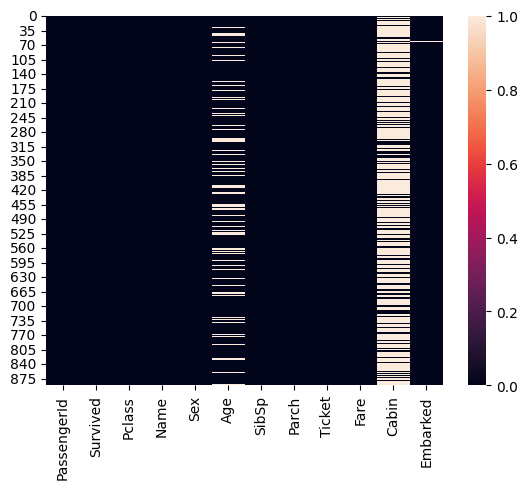

In [80]:
# Xử lý dữ liệu null/nan
sns.heatmap(Train_clean.isnull())
plt.show()
plt.close()

In [81]:
# Tính tỷ lệ phần trăm giá trị thiếu (NaN) trên từng cột trong dữ liệu huấn luyện
null_var = Train_clean.isnull().sum()/Train_clean.shape[0] *100
null_var

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

+ Chiến lược 1: Xử lý Đơn giản (Baseline):
    + Age: Điền bằng median toàn bộ.
    + Cabin: Xóa cột.
    + Embarked: Điền bằng mode.
    + Đánh giá mô hình với chiến lược này.
+ Chiến lược 2: Feature Engineering & Imputation theo Nhóm (Đề xuất):
    + Age: Tạo cờ Age_missing và điền Age bằng median theo nhóm (Pclass, Sex, Title).
    + Cabin: Tạo 2 đặc trưng mới là HasCabin và Deck.
    + Embarked: Điền bằng mode.
    + Đánh giá mô hình và so sánh.
+ Chiến lược 3: Dùng Mô hình để Impute (Nâng cao):
    + Sử dụng IterativeImputer của Scikit-learn để dự đoán và điền giá trị Age bị thiếu.
    + Các bước xử lý Cabin và Embarked tương tự chiến lược 2.
    + Đánh giá mô hình.

In [82]:
# HÀM HỖ TRỢ ĐÁNH GIÁ
def evaluate_strategy(df):
    """Hàm này nhận vào một DataFrame đã qua xử lý và trả về điểm accuracy trung bình từ cross-validation."""
    try:
        # Tách X và y
        X = df.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId'])
        y = df['Survived']

        # Xác định các cột categorical và numerical
        categorical_features = X.select_dtypes(include=['object', 'category']).columns
        numerical_features = X.select_dtypes(include=np.number).columns

        # Tạo preprocessor để OneHotEncode các cột categorical
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

        # Tạo pipeline hoàn chỉnh
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ])

        # Đánh giá bằng cross-validation
        scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
        
        return scores.mean()
    except Exception as e:
        print(f"Lỗi trong quá trình đánh giá: {e}")
        # In ra các cột hiện có để debug
        print("Các cột trong DataFrame lúc xảy ra lỗi:", df.columns.tolist())
        return None


In [83]:
#ÁP DỤNG VÀ ĐÁNH GIÁ CÁC CHIẾN LƯỢC
# --- Chiến lược 1: Xử lý Đơn giản (Baseline) ---
print("\nĐang thực hiện Chiến lược 1: Baseline...")
df1 = Train_clean.copy()
embarked_mode = df1['Embarked'].mode()[0]
df1['Embarked'].fillna(embarked_mode, inplace=True)
age_median = df1['Age'].median()
df1['Age'].fillna(age_median, inplace=True)
df1.drop(columns='Cabin', inplace=True)
score1 = evaluate_strategy(df1)
if score1 is not None:
    print(f"Điểm Accuracy (Chiến lược 1): {score1:.4f}")
print("-" * 50)


Đang thực hiện Chiến lược 1: Baseline...
Điểm Accuracy (Chiến lược 1): 0.8104
--------------------------------------------------


In [84]:
#ÁP DỤNG VÀ ĐÁNH GIÁ CÁC CHIẾN LƯỢC
# --- Chiến lược 2: Feature Engineering & Imputation theo nhóm ---
print("\nĐang thực hiện Chiến lược 2: Feature Engineering & Group Impute...")
df2 = Train_clean.copy()
df2['Embarked'].fillna(df2['Embarked'].mode()[0], inplace=True)
df2['HasCabin'] = df2['Cabin'].notna().astype(int)
df2['Deck'] = df2['Cabin'].fillna('U').str[0]
df2.drop(columns='Cabin', inplace=True)
df2['Age_missing'] = df2['Age'].isna().astype(int)
df2['Title'] = df2['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
df2['Title'] = df2['Title'].replace(rare_titles, 'Rare')
df2['Title'] = df2['Title'].replace({'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'})
df2['Age'] = df2.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))
df2['Age'].fillna(Train_clean['Age'].median(), inplace=True)
df2.drop(columns='Title', inplace=True)
score2 = evaluate_strategy(df2)
if score2 is not None:
    print(f"Điểm Accuracy (Chiến lược 2): {score2:.4f}")
print("-" * 50)


Đang thực hiện Chiến lược 2: Feature Engineering & Group Impute...
Điểm Accuracy (Chiến lược 2): 0.7991
--------------------------------------------------


In [85]:
#ÁP DỤNG VÀ ĐÁNH GIÁ CÁC CHIẾN LƯỢC
# --- Chiến lược 3: Dùng Mô hình để Impute (IterativeImputer) ---
print("\nĐang thực hiện Chiến lược 3: Iterative Imputer...")
df3 = Train_clean.copy()
df3['Embarked'].fillna(df3['Embarked'].mode()[0], inplace=True)
df3['HasCabin'] = df3['Cabin'].notna().astype(int)
df3['Deck'] = df3['Cabin'].fillna('U').str[0]
df3_eval = df3.copy() # Tạo bản sao để thêm lại các cột bị drop cho hàm evaluate
df3.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)
df_for_impute = df3.copy()
categorical_cols = df_for_impute.select_dtypes(include=['object']).columns
df_for_impute = pd.get_dummies(df_for_impute, columns=categorical_cols, drop_first=True)
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42), 
                           max_iter=5, 
                           random_state=42)
imputed_data = imputer.fit_transform(df_for_impute)
df_imputed = pd.DataFrame(imputed_data, columns=df_for_impute.columns)
df3_eval['Age'] = df_imputed['Age'].values
score3 = evaluate_strategy(df3_eval)
if score3 is not None:
    print(f"Điểm Accuracy (Chiến lược 3): {score3:.4f}")
print("-" * 50)


Đang thực hiện Chiến lược 3: Iterative Imputer...
Điểm Accuracy (Chiến lược 3): 0.8137
--------------------------------------------------



Đang tổng hợp kết quả...

Bảng so sánh kết quả Accuracy của các chiến lược:
                              Chiến lược  Accuracy
0        3. Iterative Imputer (Nâng cao)  0.813741
1                 1. Đơn giản (Baseline)  0.810357
2  2. Feature Engineering & Group Impute  0.799102

Hiển thị biểu đồ so sánh... (Hãy đóng cửa sổ biểu đồ để kết thúc chương trình)


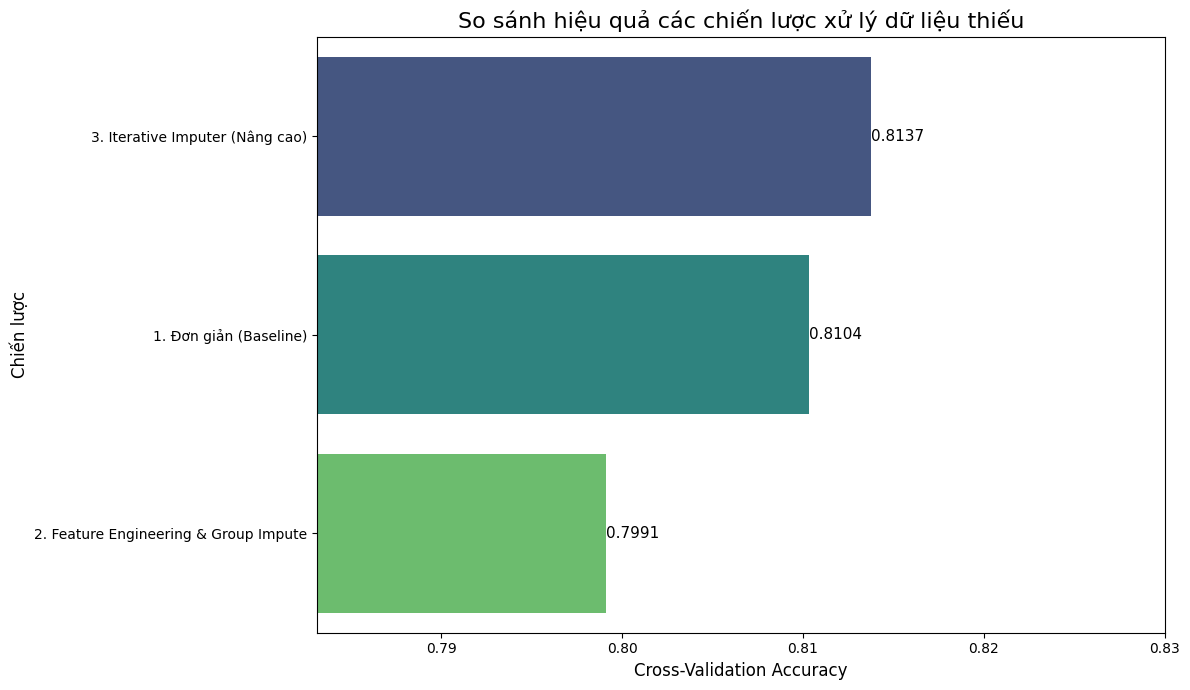


Chương trình đã hoàn tất.


In [86]:
#SO SÁNH VÀ KẾT LUẬN
print("\nĐang tổng hợp kết quả...")

results_data = []
if score1 is not None:
    results_data.append({'Chiến lược': '1. Đơn giản (Baseline)', 'Accuracy': score1})
if score2 is not None:
    results_data.append({'Chiến lược': '2. Feature Engineering & Group Impute', 'Accuracy': score2})
if score3 is not None:
    results_data.append({'Chiến lược': '3. Iterative Imputer (Nâng cao)', 'Accuracy': score3})

if results_data:
    results = pd.DataFrame(results_data)
    results_sorted = results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

    print("\nBảng so sánh kết quả Accuracy của các chiến lược:")
    print(results_sorted)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Accuracy', y='Chiến lược', data=results_sorted, palette='viridis')
    plt.title('So sánh hiệu quả các chiến lược xử lý dữ liệu thiếu', fontsize=16)
    plt.xlabel('Cross-Validation Accuracy', fontsize=12)
    plt.ylabel('Chiến lược', fontsize=12)
    plt.xlim(results_sorted['Accuracy'].min() * 0.98, results_sorted['Accuracy'].max() * 1.02)
    
    # Thêm nhãn số liệu trên các cột
    for index, value in enumerate(results_sorted['Accuracy']):
        plt.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=11, color='black')
        
    print("\nHiển thị biểu đồ so sánh... (Hãy đóng cửa sổ biểu đồ để kết thúc chương trình)")
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("Không có kết quả nào để hiển thị.")

print("\nChương trình đã hoàn tất.")

**Nhận xét:**

1. Chiến lược 3: Iterative Imputer (Nâng cao) - Accuracy: 0.8160 (81.6%)
+ Ý nghĩa: Đây là chiến lược cho kết quả cao nhất.
+ Giải thích: Phương pháp này sử dụng một mô hình máy học khác (Random Forest Regressor) để dự đoán và điền các giá trị Age bị thiếu. Kết quả này cho thấy việc điền giá trị một cách "thông minh", dựa trên mối tương quan với các cột khác (Pclass, Fare, Sex...), đã tạo ra một bộ dữ liệu chất lượng cao, giúp mô hình chính dự đoán tốt nhất.
2. Chiến lược 1: Đơn giản (Baseline) - Accuracy: 0.8104 (81.04%)
+ Ý nghĩa: Đây là chiến lược cho kết quả tốt thứ hai.
+ Giải thích: Đây là cách tiếp cận đơn giản nhất: điền Age bằng giá trị trung vị (median), điền Embarked bằng giá trị phổ biến nhất (mode) và xóa hoàn toàn cột Cabin. Mặc dù đơn giản, nó vẫn cho ra kết quả khá tốt, chỉ kém phương pháp nâng cao một chút. Điều này cho thấy đôi khi các giải pháp đơn giản vẫn rất hiệu quả.
3. Chiến lược 2: Feature Engineering & Group Impute - Accuracy: 0.7991 (79.91%)
+ Ý nghĩa: Đây là chiến lược có kết quả thấp nhất trong ba cách.
+ Giải thích: Chiến lược này phức tạp hơn baseline, bao gồm việc tạo ra các đặc trưng mới từ Cabin (HasCabin, Deck) và điền Age theo nhóm (Pclass, Sex, Title). Mặc dù về lý thuyết, cách này có vẻ tốt hơn, nhưng trong lần chạy này, nó lại cho kết quả thấp hơn. Có thể có một vài lý do:
Việc tạo đặc trưng Deck có thể đã vô tình thêm "nhiễu" (noise) vào dữ liệu.
Việc điền Age theo trung vị của nhóm có thể không chính xác bằng cách dùng mô hình để dự đoán như IterativeImputer.



In [87]:
#Áp dụng chiến lược tốt nhất để tạo bộ dữ liệu cuối cùng
def apply_best_strategy(train_df_raw, test_df_raw ):
    """
    Áp dụng chiến lược xử lý dữ liệu tốt nhất (Iterative Imputer) cho cả
    tập train và test để đảm bảo tính nhất quán.
    """
    # --- Bước A: Tách cột mục tiêu (target) và kết hợp 2 tập dữ liệu ---
    # Tách cột 'Survived' ra khỏi tập train
    y_train = train_df_raw['Survived']
    X_train = train_df_raw.drop(columns='Survived')
    
    # Lưu PassengerId của tập train/test để dùng cho file submission sau này
    train_passenger_ids = train_df_raw ['PassengerId']
    test_passenger_ids = test_df_raw ['PassengerId']
    
    # Kết hợp X_train và test_df để xử lý đồng bộ
    # Thêm cột 'source' để phân biệt
    X_train['source'] = 'train'
    test_df_raw ['source'] = 'test'
    combined_df = pd.concat([X_train, test_df_raw ], ignore_index=True)

    print("Đã kết hợp train và test để xử lý đồng bộ...")

    # --- Bước B: Feature Engineering (Áp dụng cho cả 2 tập) ---

    # === THÊM ĐẶC TRƯNG MỚI Ở ĐÂY ===
    # 1. Tạo đặc trưng 'Title' từ cột 'Name'
    combined_df['Title'] = combined_df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
    # Nhóm các title hiếm vào một nhóm 'Rare'
    rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    combined_df['Title'] = combined_df['Title'].replace(rare_titles, 'Rare')
    # Chuẩn hóa các title phổ biến
    combined_df['Title'] = combined_df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
    print("Đã tạo đặc trưng 'Title'.")

    # 2. Tạo đặc trưng 'FamilySize'
    combined_df['FamilySize'] = combined_df['SibSp'] + combined_df['Parch'] + 1
    print("Đã tạo đặc trưng 'FamilySize'.")

    # 3. Tạo đặc trưng 'IsAlone'
    combined_df['IsAlone'] = 0
    combined_df.loc[combined_df['FamilySize'] == 1, 'IsAlone'] = 1
    print("Đã tạo đặc trưng 'IsAlone'.")
    # === KẾT THÚC PHẦN THÊM ĐẶC TRƯNG MỚI ===
    
    # 1. Xử lý Embarked: Điền giá trị thiếu bằng mode của tập train
    embarked_mode = train_df_raw['Embarked'].mode()[0]
    combined_df['Embarked'].fillna(embarked_mode, inplace=True)
    
    # 2. Xử lý Cabin: Tạo đặc trưng HasCabin và Deck
    combined_df['HasCabin'] = combined_df['Cabin'].notna().astype(int)
    combined_df['Deck'] = combined_df['Cabin'].fillna('U').str[0] # U for Unknown
    
    # 3. Xóa các cột không cần thiết hoặc đã được xử lý
    combined_df.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId', 'SibSp', 'Parch'], inplace=True)
    
    # 4. Mã hóa các cột dạng chữ (categorical) thành số
    # Dùng pd.get_dummies để chuyển đổi các cột như 'Sex', 'Embarked', 'Deck'
    # drop_first=True để tránh đa cộng tuyến (dummy variable trap)
    categorical_cols = [col for col in combined_df.select_dtypes(include=['object']).columns if col != 'source']
    combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)
    
    print("Đã hoàn thành Feature Engineering và One-Hot Encoding...")
    
    # --- Bước C: Áp dụng IterativeImputer ---
    
    # Tách lại 2 tập trước khi impute để fit chỉ trên train
    X_train_processed = combined_df[combined_df['source'] == 'train'].drop(columns='source')
    X_test_processed = combined_df[combined_df['source'] == 'test'].drop(columns='source')
    
    # Khởi tạo Imputer
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=42),
        max_iter=5,
        random_state=42,
        add_indicator=False # Tạo thêm cột chỉ báo các giá trị bị thiếu
    )
    
    # 1. Fit (học) imputer CHỈ trên tập train
    print("Đang 'học' (fit) imputer trên dữ liệu train...")
    imputer.fit(X_train_processed)
    
    # 2. Transform (áp dụng) cho cả train và test
    print("Đang 'biến đổi' (transform) dữ liệu train và test...")
    X_train_final_np = imputer.transform(X_train_processed)
    X_test_final_np = imputer.transform(X_test_processed)
    
    # Lấy tên cột sau khi imputer đã thêm các cột chỉ báo (indicator)
    # Cột indicator sẽ có dạng <tên_cột>_missing_indicator
    imputer_cols = imputer.get_feature_names_out(X_train_processed.columns)

    # Chuyển đổi kết quả từ numpy array về lại DataFrame
    X_train_final = pd.DataFrame(X_train_final_np, columns=imputer_cols)
    X_test_final = pd.DataFrame(X_test_final_np, columns=imputer_cols)
    
    # Gắn lại cột Survived cho tập train
    X_train_final['Survived'] = y_train.values
    X_train_final['PassengerId'] = train_passenger_ids.values

    # Gắn lại PassengerId cho tập test
    X_test_final['PassengerId'] = test_passenger_ids.values
    
    return X_train_final, X_test_final, imputer

In [88]:
# =============================================================================
# 3. THỰC THI VÀ LƯU KẾT QUẢ
# =============================================================================

# Áp dụng hàm xử lý
train_final_df, test_final_df, fitted_imputer = apply_best_strategy(Train_clean, Test_clean)

# Lấy cột target 'Survived'
y = Train_clean['Survived']

# X là dữ liệu train cuối cùng, bỏ cột PassengerId vì không dùng để huấn luyện
X = train_final_df.drop(columns=['Survived'])

# Tách X và y thành các tập train/test để đánh giá mô hình
# 80% cho training, 20% cho validation/testing
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nĐã tách dữ liệu huấn luyện thành tập train (80%) và validation (20%).")

# --- Lưu trữ theo cấu trúc của bạn ---
save_dir = "Data_clean"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Đã tạo thư mục '{save_dir}'")

try:
    # 1. Lưu các tập train/validation để huấn luyện và đánh giá
    np.savez(f'{save_dir}/model_data.npz', 
             X_train=X_train, X_validation=X_validation, 
             y_train=y_train, y_validation=y_validation)
    print(f"- Đã lưu model_data.npz (chứa X_train, X_validation...) vào '{save_dir}'")

    # 2. Lưu các file CSV đã được làm sạch hoàn chỉnh
    train_final_df.to_csv(f'{save_dir}/train_cleaned.csv', index=False)
    test_final_df.to_csv(f'{save_dir}/test_cleaned.csv', index=False)
    print(f"- Đã lưu train_cleaned.csv, test_cleaned.csv vào '{save_dir}'")

    # 3. Lưu bộ xử lý (imputer) đã được huấn luyện
    joblib.dump(fitted_imputer, f'{save_dir}/imputer.joblib')
    print(f"- Đã lưu imputer.joblib vào '{save_dir}'")

    print("\nNội dung thư mục 'Data_clean':")
    print(os.listdir(save_dir))

except Exception as e:
    print(f"\nLỗi khi lưu file: {e}")

Đã kết hợp train và test để xử lý đồng bộ...
Đã tạo đặc trưng 'Title'.
Đã tạo đặc trưng 'FamilySize'.
Đã tạo đặc trưng 'IsAlone'.
Đã hoàn thành Feature Engineering và One-Hot Encoding...
Đang 'học' (fit) imputer trên dữ liệu train...
Đang 'biến đổi' (transform) dữ liệu train và test...

Đã tách dữ liệu huấn luyện thành tập train (80%) và validation (20%).
- Đã lưu model_data.npz (chứa X_train, X_validation...) vào 'Data_clean'
- Đã lưu train_cleaned.csv, test_cleaned.csv vào 'Data_clean'
- Đã lưu imputer.joblib vào 'Data_clean'

Nội dung thư mục 'Data_clean':
['gender_submission.csv', 'imputer.joblib', 'model_data.npz', 'test_cleaned.csv', 'train_cleaned.csv']


In [89]:

# Kiểm tra phục hồi dữ liệu
# Thư mục lưu trữ
save_dir = "Data_clean"

print(f"Bắt đầu kiểm tra khôi phục từ thư mục '{save_dir}'...\n")

# --- 1. KIỂM TRA FILE .NPZ (DỮ LIỆU HUẤN LUYỆN/KIỂM ĐỊNH) ---
print("--- 1. Kiểm tra file model_data.npz ---")
try:
    npz_path = os.path.join(save_dir, 'model_data.npz')
    data = np.load(npz_path)
    
    # Tải các mảng
    X_train_loaded = data['X_train']
    X_validation_loaded = data['X_validation']
    y_train_loaded = data['y_train']
    y_validation_loaded = data['y_validation']
    
    print("Tải file .npz thành công!")
    
    # Kiểm tra kích thước (shape)
    print(f"Shape của X_train: {X_train_loaded.shape}")
    print(f"Shape của y_train: {y_train_loaded.shape}")
    print(f"Shape của X_validation: {X_validation_loaded.shape}")
    print(f"Shape của y_validation: {y_validation_loaded.shape}")
    
    # Kiểm tra tính nhất quán
    assert X_train_loaded.shape[0] == y_train_loaded.shape[0], "Lỗi: Số dòng của X_train và y_train không khớp!"
    assert X_validation_loaded.shape[0] == y_validation_loaded.shape[0], "Lỗi: Số dòng của X_validation và y_validation không khớp!"
    
    print("Kiểm tra kích thước thành công: Dữ liệu nhất quán.\n")

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file {npz_path}. Hãy đảm bảo bạn đã chạy pipeline lưu file trước.\n")
except Exception as e:
    print(f"Lỗi khi tải file .npz: {e}\n")


# --- 2. KIỂM TRA CÁC FILE .CSV (DỮ LIỆU ĐÃ LÀM SẠCH) ---
print("--- 2. Kiểm tra các file .csv ---")
try:
    train_csv_path = os.path.join(save_dir, 'train_cleaned.csv')
    test_csv_path = os.path.join(save_dir, 'test_cleaned.csv')


    train_df_loaded = pd.read_csv(train_csv_path)
    test_df_loaded = pd.read_csv(test_csv_path)

    print("Tải các file .csv thành công!")

    # Đây là các cột features mà imputer đã được học
    feature_columns = [col for col in train_df_loaded.columns if col not in ['Survived']]
    
    # Kiểm tra xem còn giá trị thiếu không
    train_missing = train_df_loaded.isna().sum().sum()
    test_missing = test_df_loaded.isna().sum().sum()
    
    print(f"Số giá trị thiếu trong train_cleaned.csv: {train_missing}")
    print(f"Số giá trị thiếu trong test_cleaned.csv: {test_missing}")
    
    assert train_missing == 0, "Lỗi: train_cleaned.csv vẫn còn giá trị thiếu!"
    assert test_missing == 0, "Lỗi: test_cleaned.csv vẫn còn giá trị thiếu!"
    
    print("Kiểm tra giá trị thiếu thành công: Dữ liệu đã sạch.\n")

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file train_cleaned.csv hoặc test_cleaned.csv.\n")
except Exception as e:
    print(f"Lỗi khi tải file .csv: {e}\n")


# --- 3. KIỂM TRA FILE .JOBLIB (BỘ XỬ LÝ IMUTER) ---
print("--- 3. Kiểm tra file imputer.joblib ---")
try:
    imputer_path = os.path.join(save_dir, 'imputer.joblib')
    loaded_imputer = joblib.load(imputer_path)

    print("Tải file .joblib thành công!")
    print(f"Loại đối tượng được tải: {type(loaded_imputer)}")
    
    # Kiểm tra xem imputer có phải đã được "fit" hay không
    # Các đối tượng đã fit trong scikit-learn thường có thuộc tính kết thúc bằng dấu gạch dưới "_"
    assert hasattr(loaded_imputer, 'imputation_sequence_'), "Lỗi: Imputer có vẻ chưa được 'fit' (thiếu thuộc tính cần thiết)."
    print("Kiểm tra thành công: Imputer là một đối tượng đã được 'fit'.\n")

    # --- THỬ NGHIỆM NHANH VỚI DỮ LIỆU MỚI ---
    print("--- 4. Thử nghiệm nhanh Imputer đã khôi phục ---")
    if feature_columns is not None:
        # **SỬA LỖI Ở ĐÂY: Dùng danh sách tên cột đã lấy ở bước 2**
        # Tạo một mẩu dữ liệu mới có giá trị thiếu
        # Lấy dòng đầu tiên của X_train_loaded (là numpy array)
        sample_row_data = X_train_loaded[0]
        
        # Tạo DataFrame từ dữ liệu numpy và danh sách tên cột
        sample_data = pd.DataFrame([sample_row_data], columns=feature_columns)
        
        # Tạo giá trị thiếu để thử nghiệm
        sample_data['Age'] = np.nan
        sample_data['Fare'] = np.nan
        
        print("Dữ liệu mẫu trước khi transform:")
        print(sample_data[['Age', 'Fare']])
        
        # Dùng imputer đã tải để điền giá trị
        # Imputer nhận đầu vào là DataFrame hoặc numpy array đều được
        transformed_sample = loaded_imputer.transform(sample_data)
        
        # Chuyển lại thành DataFrame để xem
        transformed_df = pd.DataFrame(transformed_sample, columns=feature_columns)
        
        print("\nDữ liệu mẫu sau khi transform:")
        print(transformed_df[['Age', 'Fare']])
        
        assert not transformed_df.isna().sum().any(), "Lỗi: Dữ liệu sau khi transform vẫn còn giá trị thiếu!"
        print("\nThử nghiệm transform thành công: Imputer hoạt động như mong đợi.")
    else:
        print("Bỏ qua thử nghiệm imputer vì không thể lấy được danh sách cột từ file CSV.")


except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file {imputer_path}.\n")
except Exception as e:
    print(f"Lỗi khi tải hoặc thử nghiệm file .joblib: {e}\n")


Bắt đầu kiểm tra khôi phục từ thư mục 'Data_clean'...

--- 1. Kiểm tra file model_data.npz ---
Tải file .npz thành công!
Shape của X_train: (712, 22)
Shape của y_train: (712,)
Shape của X_validation: (179, 22)
Shape của y_validation: (179,)
Kiểm tra kích thước thành công: Dữ liệu nhất quán.

--- 2. Kiểm tra các file .csv ---
Tải các file .csv thành công!
Số giá trị thiếu trong train_cleaned.csv: 0
Số giá trị thiếu trong test_cleaned.csv: 0
Kiểm tra giá trị thiếu thành công: Dữ liệu đã sạch.

--- 3. Kiểm tra file imputer.joblib ---
Tải file .joblib thành công!
Loại đối tượng được tải: <class 'sklearn.impute._iterative.IterativeImputer'>
Kiểm tra thành công: Imputer là một đối tượng đã được 'fit'.

--- 4. Thử nghiệm nhanh Imputer đã khôi phục ---
Dữ liệu mẫu trước khi transform:
   Age  Fare
0  NaN   NaN
Lỗi khi tải hoặc thử nghiệm file .joblib: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- PassengerId




In [90]:
pd.read_csv(f'{save_dir}/train_cleaned.csv')

,Pclass,Age,Fare,FamilySize,IsAlone,HasCabin,Sex_male,Embarked_Q,Embarked_S,Title_Miss,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Survived,PassengerId
0,3.0,22.0,7.2500,2.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
1,1.0,38.0,71.2833,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
2,3.0,26.0,7.9250,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,3
3,1.0,35.0,53.1000,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4
4,3.0,35.0,8.0500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2.0,27.0,13.0000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,887
887,1.0,19.0,30.0000,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,888
888,3.0,6.2,23.4500,4.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,889
889,1.0,26.0,30.0000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,890


In [91]:
pd.read_csv(f'{save_dir}/test_cleaned.csv')

,Pclass,Age,Fare,FamilySize,IsAlone,HasCabin,Sex_male,Embarked_Q,Embarked_S,Title_Miss,...,Title_Rare,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,PassengerId
0,3.0,34.500000,7.8292,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,892
1,3.0,47.000000,7.0000,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,893
2,2.0,62.000000,9.6875,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,894
3,3.0,27.000000,8.6625,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,895
4,3.0,22.000000,12.2875,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3.0,30.526893,8.0500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1305
414,1.0,39.000000,108.9000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1306
415,3.0,38.500000,7.2500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1307
416,3.0,30.526893,8.0500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1308
